# Renewable energy sources optimization

### Problem formulation

We want to optimize the distribution of the energy load coming from multiple sources.
We have to satisfy the demand of several customers, and to minimize the overall cost.
Let us take a simplified example, with two renewable energies sources and two customers.

### Parameters

- **Energy Sources**: Solar and Wind, each with different capacities and costs.
  
  | Source            | Capacity (kW) | Cost (€/kW) |
  |-------------------|---------------|-------------|
  | Solar | 100           | 0.15        |                    
  |  Wind | 150           | 0.20        |                   

- **Customers**: A & B, each with a specific energy demand.
    - Consumer A: $D_A$ = 90 kW
    - Consumer B: $D_B$ = 120 kW

- **Objective**: Minimize the total cost of energy distribution while meeting all consumer demands without exceeding the source capacities.

- **Tools**: Linear programming, Quadratic Programming...

- An analytical solution is possible as well (look [here](https://math.stackexchange.com/questions/4909516/linear-optimization-using-lagrange-multipliers/4909626#4909626))



### Formulation

- **Variables**:
    - $x_{i,a}$: Amount of energy transferred from source $i$ to consumer $a$.
- **Objective**
    We can define a linear cost, to be minimized:
    $$ \text{Cost} = cost_I \times (x_{I,A} + x_{I,B}) + cost_J \times(x_{J,A} + x_{J,B}) $$
- **Constraints**
  At any time these constraint must be met:
    1. Total energy supplied to each consumer meets their demand.
        - Demand of Consumer A: $x_{I,A} + x_{J,A} = D_A$
        - Demand of Consumer B: $x_{I,B} + x_{J,B} = D_B$
    2. The total energy taken from each source does not exceed its capacity.
        - Solar capacity: $x_{I,A} + x_{I,B} \leq S_{max}$
        - Wind capacity: $x_{J,A} + x_{J,B} \leq W_{max}$
    3. All energies must be positive
       - $x_{i,a} \geq 0$ for any $(i, a)$
         

# EnergySource, Consumer, EnergyDistribution classes

Let us take advantage of three classes to store and validate data

In [1]:
from optimization.core.renewables import EnergySource, Consumer, EnergyDistribution

# Create EnergySource instances
solar = EnergySource("Solar", 100, 0.3)
wind = EnergySource("Wind", 150, 0.25)

# Create Consumer instances
consumer_a = Consumer("A", 90.)
consumer_b = Consumer("B", 120.)

# Create the energy distribution system
system = EnergyDistribution()

system.add_source(solar)
system.add_source(wind)

system.add_consumer(consumer_a)
system.add_consumer(consumer_b)

### Test guess solution

The guess solution is proposed as a numpy array, the first column being the solar demand, and the second one is wind requirement. The row corrsespond to Customers A and B respectively.

We can use the `cost_function` method implemented in the `EnergyDistribution` class.

Note that the `test=True` options trigger the `check_solution_integrity` method which verifies that the problem requirements are satisfied. If a solution does not respect the constraint, an error will be raised.

In [2]:
import numpy as np

guess_solution = np.array([
    [20., 70.],  # >> Customer A 
    [80., 40.],  # >> Customer B
]) 

system.cost_function(guess_solution, test=True)

57.5

# Find optimal solution

In [3]:
from scipy.optimize import minimize

x = np.array([1., 1., 1., 1.])

# Constraints
constraints = [
    {'type': 'ineq', 'fun': lambda x: solar.capacity - x[0::2].sum()}, # Sum of xs and ys should not exceed solar capacity
    {'type': 'ineq', 'fun': lambda x: wind.capacity - x[1::2].sum()},  # Sum of xw and yw should not exceed wind capacity
    {'type': 'eq', 'fun': lambda x: x[0:2].sum() - consumer_a.demand},   # Sum of xs and xw equals consumer_a's demand
    {'type': 'eq', 'fun': lambda x: x[2:4].sum() - consumer_b.demand},   # Sum of ys and yw equals consumer_b's demand
]


In [4]:
# Solve
max_capacity = max( solar.capacity, wind.capacity )

solution = minimize(
    system.cost_function,  
    x, 
    constraints=constraints,
    bounds = len(x)*[(0,max_capacity)],
    method='SLSQP',
    options={'disp': True,'maxiter' : 1e6}
)

solution

Optimization terminated successfully    (Exit mode 0)
            Current function value: 55.5
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 55.5
       x: [ 2.250e+01  6.750e+01  3.750e+01  8.250e+01]
     nit: 8
     jac: [ 3.000e-01  2.500e-01  3.000e-01  2.500e-01]
    nfev: 40
    njev: 8

# Visualization

Let us create a set of possible solutions and plot them.

In [10]:
solutions = []
for _ in range(100):
    
    solution = system.generate_one_solution()
    if solution not in solutions:
        cost = system.cost_function(solution)
        solutions.append(solution)
        
solutions

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [67]:
import numpy as np

solutions = []
costs = []
solution_hashes = set()  # To store hashes of arrays for quick membership checks
cost_min, cost_max = 1e3, -1e3

for _ in range(1000):
    solution = system.generate_one_solution()
    solution_tuple = tuple(map(tuple, solution))  # Convert array to a tuple of tuples

    if solution_tuple not in solution_hashes:
        cost = system.cost_function(solution)
        if cost < cost_min:
            cost_min = cost
        if cost > cost_max:
            cost_max = cost
        solutions.append(solution)
        costs.append(cost)
        solution_hashes.add(solution_tuple)  # Store the hashable version
    else:
        print('Solution already present')


In [68]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Create a normalization from x to y
norm = Normalize(vmin=cost_min, vmax=cost_max)
    
# Get the colormap
cmap = cm.get_cmap('inferno')
    
# Create a function that maps normalized data to colors
cmap_normalized = cm.ScalarMappable(norm=norm, cmap=cmap)

/tmp/ipykernel_18124/2060370032.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


In [69]:
for (solution, cost) in solutions:
    xw, xs, yw, wx = solution.flatten()

    plt.scatter(xw, yw)

ValueError: not enough values to unpack (expected 4, got 2)

In [73]:
solutions[:,:][0]

TypeError: list indices must be integers or slices, not tuple

In [66]:
solutions[:2][:]

[(array([[ 4.06977858, 85.93022142],
         [56.92410523, 63.07589477]]),
  55.54969419052182),
 (array([[ 80.55099874,   9.44900126],
         [ 19.09214473, 100.90785527]]),
  57.48215717332477)]

ValueError: x and y must be the same size

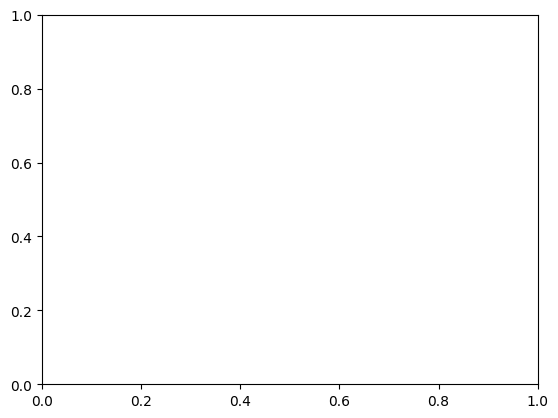

In [51]:
plt.scatter(
    solutions[0][0], 
    solutions[0][1], 
    c=solutions[1], cmap='viridis')  # Use 'c' for color mapping



In [ ]:
import numpy as np

def objective(x, y):
    return solar.cost_per_unit * x + wind.cost_per_unit * (y - y**2)

x = np.linspace(0, 1000, 100)
y = np.linspace(0, 100, 100)
X, Y = np.meshgrid(x, y)
Z = objective(X, Y)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, 20, cmap='viridis')  # Use a colormap like 'viridis', 'hot', 'cool', etc.
plt.colorbar()  # Adds a color bar to indicate the scale
plt.title('Heatmap of objective function')
plt.xlabel('Wind')
plt.ylabel('Solar')
plt.show()


In [ ]:
from itertools import product

def generate_matrix(xrange):    
    for indices in product(*[xrange] * 6):
        yield np.array(indices)

In [ ]:
xgrid = generate_matrix(xrange)

min_cost = 1e9

print(consumer_a.demand)
for x_vector in generate_matrix(xrange):
    
    if x_vector[0:2].sum() == consumer_a.demand and \
       x_vector[2:4].sum() == consumer_b.demand and \
       x_vector[4:6].sum() == consumer_c.demand and \
       x_vector[0::2].sum() <= solar.capacity and \
       x_vector[1::2].sum() <= wind.capacity:

        print(x_vector, x_vector[0::2].sum())
        
        cost = cost_function_vector(x_vector)
        
        if cost <= min_cost:
            min_cost = cost 
            print(x_vector, min_cost)

In [ ]:
from scipy.optimize import minimize

max_capacity = max( solar.capacity, wind.capacity )
x_guess = x_array.flatten()

print(x_vector)

res = minimize(
    #cost_function_vector,
    lambda x: solar.cost_per_unit * x_guess[0::2].sum() + wind.cost_per_unit * x_guess[1::2].sum(), #what we want to minimize
    x_guess, 

    bounds = ((0,max_capacity),(0,max_capacity),(0,max_capacity),(0,max_capacity),(0,max_capacity),(0,max_capacity)),
    method='SLSQP',options={'disp': True,'maxiter' : 100000}
)

res


import numpy as np
from scipy.optimize import minimize

# Objective function
def objective(x):
    xs, xw, ys, yw = x
    return a * (xs + ys) + b * (xw + yw)

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda x: x[0] + x[1] - Dx},  # xs + xw = Dx
    {'type': 'ineq', 'fun': lambda x: S - (x[0] + x[2])},  # xs + ys <= S
    {'type': 'eq', 'fun': lambda x: x[2] + x[3] - Dy},  # ys + yw = Dy
    {'type': 'ineq', 'fun': lambda x: W - (x[1] + x[3])}  # xw + yw <= W
]

# Coefficients
a = 0.3
b = 0.1
Dx = 13
S = 20
Dy = 10
W = 15

# Initial guesses
x0 = np.array([1, 1, 1, 1])

# Solve
solution = minimize(objective, x0, constraints=constraints)
print(solution)

In [ ]:
print(res)
print(res.fun)

### TensorFlow Implementation

We will use TensorFlow to approximate a solution via a gradient descent approach, treating constraints as penalty terms in the loss function.

In [ ]:
import tensorflow as tf

# Initialize variables
x_solar_A = tf.Variable(x_guess[0] , trainable=True)  
x_solar_B = tf.Variable(x_guess[2], trainable=True)
x_solar_C = tf.Variable(x_guess[4], trainable=True)
x_wind_A = tf.Variable(x_guess[1], trainable=True)
x_wind_B = tf.Variable(x_guess[3], trainable=True)
x_wind_C = tf.Variable(x_guess[5], trainable=True)

# Define constraints as penalties
def capacity_constraints():
    return [
        solar.capacity - (x_solar_A + x_solar_B + x_solar_C),  # Solar capacity
        wind.capacity - (x_wind_A + x_wind_B + x_wind_C),    # Wind capacity
        x_solar_A + x_wind_A - consumer_a.demand, # Demand of Consumer A
        x_solar_B + x_wind_B - consumer_b.demand, # Demand of Consumer B
        x_solar_C + x_wind_C - consumer_c.demand  # Demand of Consumer C
    ]

# Define sources, consumers, and their capacities and demands here

# Cost function
cost = solar.cost_per_unit * ( x_solar_A + x_solar_B + x_solar_C ) + wind.cost_per_unit * ( x_wind_A + x_wind_B + x_wind_C )

# Optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)
optimizer = tf.optimizers.SGD(learning_rate=0.0001)  # Adjust learning rate here

# Training step
def train_step():
    with tf.GradientTape() as tape:
        constraints = capacity_constraints()
        penalty = tf.reduce_sum(tf.square(constraints))  # Squared penalties for constraint violation
        loss = cost + penalty
    gradients = tape.gradient(loss, [x_solar_A, x_solar_B, x_solar_C, x_wind_A, x_wind_B, x_wind_C])
    optimizer.apply_gradients(zip(gradients, [x_solar_A, x_solar_B, x_solar_C, x_wind_A, x_wind_B, x_wind_C]))
    return loss  # Return the loss value

# Optimization loop
for i in range(100):
    loss = train_step()
    if (i + 1) % 10 == 0:  # Print cost every 100 iterations
        print(f"Iteration {i + 1}, Cost: {loss.numpy()}")


In [ ]:
# Output the results
print(f'           |   Solar            |  Wind')
print(f'Consumer A |{x_solar_A.numpy()}  | {x_wind_A.numpy()}')
print(f'Consumer B |{x_solar_B.numpy()}  | {x_wind_B.numpy()}')
print(f'Consumer C |{x_solar_C.numpy()}  | {x_wind_C.numpy()}')


In [ ]:
loss.numpy()